# 07 - Forensic and UXO Applications

Two realistic operational scenarios demonstrating Pathfinder capabilities:

**Part A: Forensic Grave Search** — `clandestine-burial.json`  
**Part B: UXO Clearance** — `bomb-crater-heterogeneous.json`  
**Part C: Operational Comparison**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile

from geosim.scenarios.loader import load_scenario
from geosim.sensors.pathfinder import (
    PathfinderConfig, generate_zigzag_path, simulate_survey, run_scenario_survey,
)
from geosim.magnetics.dipole import (
    gradiometer_reading, superposition_field, detection_depth_estimate,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

---
## Part A: Forensic Grave Search

**Scenario:** A clandestine burial with a disturbed grave shaft containing:
- Belt buckle (0.9m depth)
- Shoe eyelets and zipper (1.1m depth)  
- Dropped shovel head (0.4m depth, nearby)

In [2]:
burial = load_scenario(Path('..') / 'scenarios' / 'clandestine-burial.json')

print(f'Scenario: {burial.name}')
print(f'Terrain: {burial.terrain.x_extent[1]}m x {burial.terrain.y_extent[1]}m')
print(f'Objects: {len(burial.objects)}')
print()
for obj in burial.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    depth = abs(obj.position[2])
    depth_est = detection_depth_estimate(m_mag, 50e-12, 0.35) if m_mag > 0 else 0
    print(f'  {obj.name:<30} depth={depth:.1f}m  |m|={m_mag:.6f} A*m\u00b2  max_depth={depth_est:.1f}m')

Scenario: Clandestine Burial
Terrain: 15.0m x 15.0m
Objects: 3

  Belt buckle                    depth=0.9m  |m|=0.003916 A*m²  max_depth=1.9m
  Shoe eyelets and zipper        depth=1.1m  |m|=0.001650 A*m²  max_depth=1.6m
  Dropped tool (shovel head)     depth=0.4m  |m|=0.105970 A*m²  max_depth=3.6m


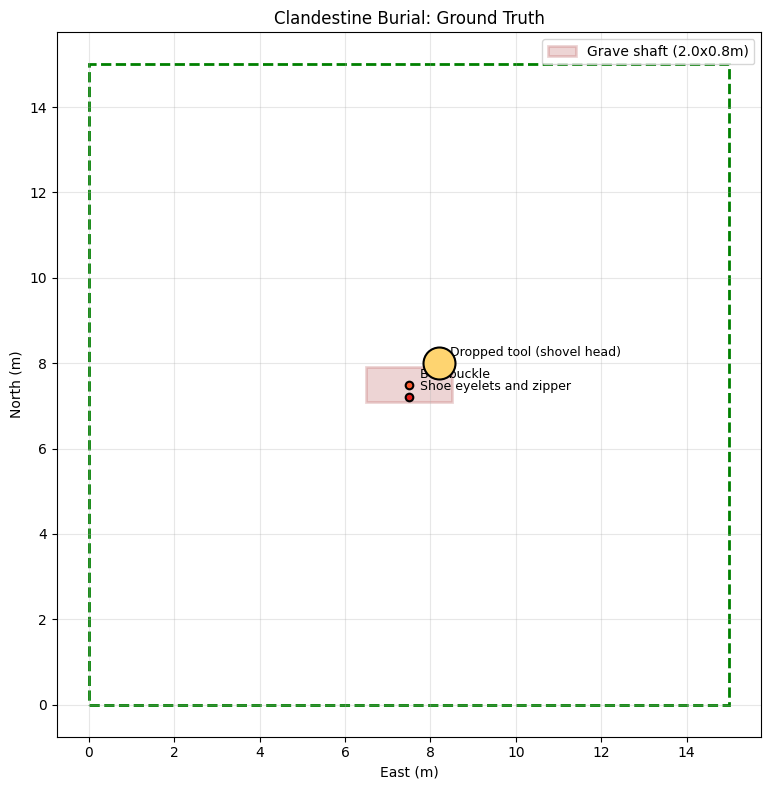

In [3]:
# Ground truth map with grave outline
fig, ax = plt.subplots(figsize=(8, 8))

x_ext = burial.terrain.x_extent
y_ext = burial.terrain.y_extent
ax.add_patch(plt.Rectangle(
    (x_ext[0], y_ext[0]), x_ext[1]-x_ext[0], y_ext[1]-y_ext[0],
    fill=False, edgecolor='green', lw=2, ls='--'
))

# Grave outline from metadata
grave = burial.metadata.get('grave_dimensions', {})
if grave:
    gc = [7.5, 7.5]  # approximate center from object positions
    gl, gw = grave.get('length', 2.0), grave.get('width', 0.8)
    ax.add_patch(plt.Rectangle(
        (gc[0]-gl/2, gc[1]-gw/2), gl, gw,
        fill=True, facecolor='brown', alpha=0.2, edgecolor='brown',
        lw=2, ls='-', label=f'Grave shaft ({gl}x{gw}m)'
    ))

for obj in burial.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    size = max(30, m_mag * 5000)
    ax.scatter(obj.position[0], obj.position[1], s=size,
               c=obj.position[2], cmap='YlOrRd_r', vmin=-1.5, vmax=0,
               edgecolors='black', linewidth=1.5, zorder=5)
    ax.annotate(obj.name, (obj.position[0], obj.position[1]),
                xytext=(8, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Clandestine Burial: Ground Truth')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

In [4]:
# Run survey at 0.5m line spacing (detailed forensic survey)
with tempfile.TemporaryDirectory() as tmpdir:
    burial_data = run_scenario_survey(
        Path('..') / 'scenarios' / 'clandestine-burial.json',
        Path(tmpdir) / 'burial.csv',
        line_spacing=0.5,
        seed=42,
    )

print(f'Survey samples: {len(burial_data["timestamp"])}')

Survey samples: 4800


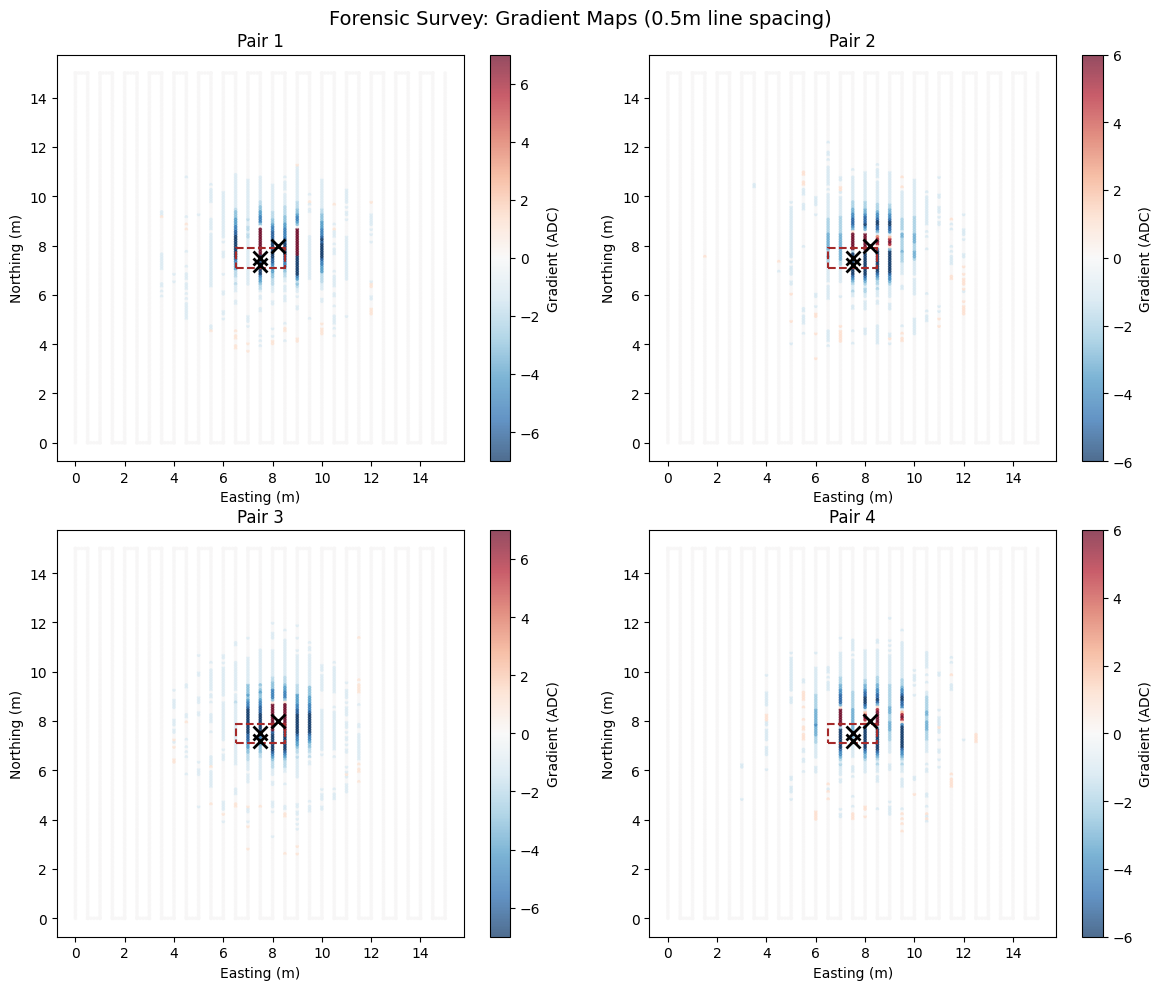

In [5]:
# 2x2 gradient maps (all 4 sensor pairs)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Forensic Survey: Gradient Maps (0.5m line spacing)', fontsize=14)

for idx, ax in enumerate(axes.flat):
    pair = idx + 1
    grad = burial_data[f'g{pair}_grad']
    vmax = max(np.percentile(np.abs(grad), 99), 1)

    sc = ax.scatter(
        burial_data['lon'], burial_data['lat'], c=grad,
        cmap='RdBu_r', s=3, alpha=0.7,
        vmin=-vmax, vmax=vmax,
    )
    plt.colorbar(sc, ax=ax, label='Gradient (ADC)')

    for obj in burial.objects:
        ax.plot(obj.position[0], obj.position[1], 'kx', markersize=10, markeredgewidth=2)

    if grave:
        ax.add_patch(plt.Rectangle(
            (gc[0]-gl/2, gc[1]-gw/2), gl, gw,
            fill=False, edgecolor='brown', lw=1.5, ls='--'
        ))

    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(f'Pair {pair}')
    ax.set_aspect('equal')

plt.tight_layout()

In [6]:
# Detection analysis
noise_threshold = 20  # ADC counts

print('Forensic Detection Analysis:')
print(f'{"Object":<30} {"Depth":>6} {"Moment":>12} {"Peak Grad":>12} {"Status":>10}')
print('-' * 74)

for obj in burial.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    depth = abs(obj.position[2])

    dx = burial_data['lon'] - obj.position[0]
    dy = burial_data['lat'] - obj.position[1]
    dist = np.sqrt(dx**2 + dy**2)
    nearby = dist < 2.0

    if nearby.any():
        peak_grad = max(np.abs(burial_data[f'g{p}_grad'][nearby]).max() for p in range(1, 5))
    else:
        peak_grad = 0

    status = 'DETECTED' if peak_grad > noise_threshold * 3 else 'marginal' if peak_grad > noise_threshold else 'below'
    print(f'{obj.name:<30} {depth:>5.1f}m {m_mag:>11.6f} {peak_grad:>10.0f} ADC {status:>10}')

Forensic Detection Analysis:
Object                          Depth       Moment    Peak Grad     Status
--------------------------------------------------------------------------
Belt buckle                      0.9m    0.003916        195 ADC   DETECTED
Shoe eyelets and zipper          1.1m    0.001650        195 ADC   DETECTED
Dropped tool (shovel head)       0.4m    0.105970        195 ADC   DETECTED


---
## Part B: UXO Clearance

**Scenario:** An 8m diameter, 5m deep bomb crater with heterogeneous fill,
containing an unexploded bomb at 3.5m depth plus fragment clusters and debris.

In [7]:
crater = load_scenario(Path('..') / 'scenarios' / 'bomb-crater-heterogeneous.json')

print(f'Scenario: {crater.name}')
print(f'Terrain: {crater.terrain.x_extent[1]}m x {crater.terrain.y_extent[1]}m')
print(f'Objects: {len(crater.objects)}')
print()
for obj in crater.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    depth = abs(obj.position[2])
    print(f'  {obj.name:<35} depth={depth:.1f}m  |m|={m_mag:.4f} A*m\u00b2')

Scenario: Bomb Crater with Heterogeneous Fill
Terrain: 25.0m x 25.0m
Objects: 6

  UXB (unexploded bomb)               depth=3.5m  |m|=1.6595 A*m²
  Bomb fragment cluster A             depth=1.5m  |m|=0.2506 A*m²
  Bomb fragment cluster B             depth=2.0m  |m|=0.1057 A*m²
  Metal pipe (wartime infrastructure) depth=1.0m  |m|=0.0312 A*m²
  Small ordnance (submunition)        depth=0.8m  |m|=0.0133 A*m²
  Rebar from destroyed structure      depth=0.5m  |m|=0.0132 A*m²


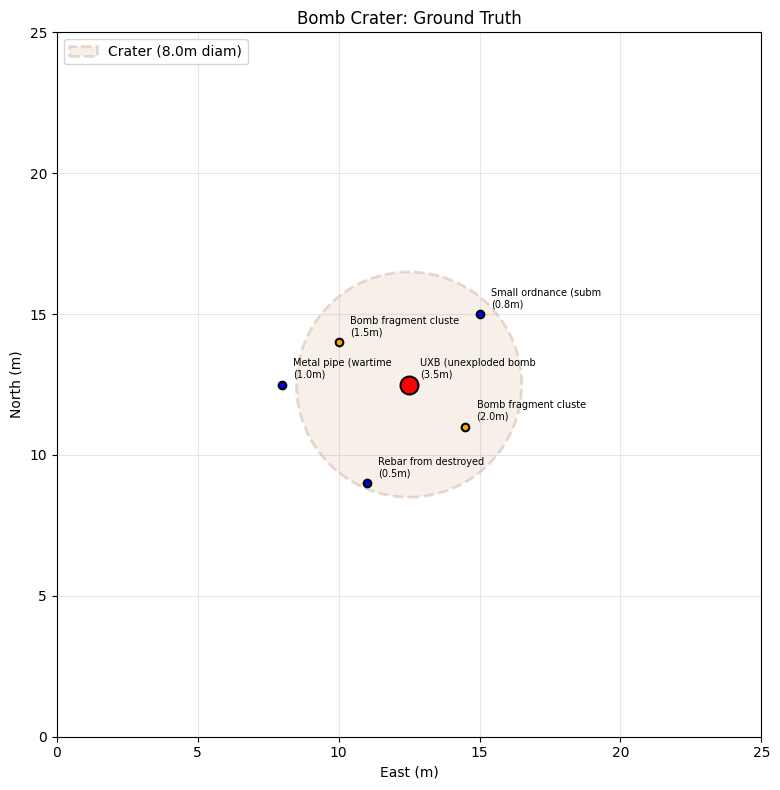

In [8]:
# Ground truth with crater outline
fig, ax = plt.subplots(figsize=(8, 8))

crater_meta = crater.metadata.get('crater', {})
if crater_meta:
    cc = crater_meta.get('center', [12.5, 12.5])
    diam = crater_meta.get('diameter', 8.0)
    circle = plt.Circle(cc, diam/2, fill=True, facecolor='tan', alpha=0.2,
                        edgecolor='sienna', lw=2, ls='--', label=f'Crater ({diam}m diam)')
    ax.add_patch(circle)

for obj in crater.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    depth = abs(obj.position[2])
    size = max(30, m_mag * 100)
    color = 'red' if 'UXB' in obj.name else 'orange' if 'fragment' in obj.name.lower() else 'blue'
    ax.scatter(obj.position[0], obj.position[1], s=size, c=color,
               edgecolors='black', linewidth=1.5, zorder=5)
    ax.annotate(f'{obj.name[:20]}\n({depth:.1f}m)', (obj.position[0], obj.position[1]),
                xytext=(8, 5), textcoords='offset points', fontsize=7)

ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Bomb Crater: Ground Truth')
ax.set_aspect('equal')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(crater.terrain.x_extent)
ax.set_ylim(crater.terrain.y_extent)

plt.tight_layout()

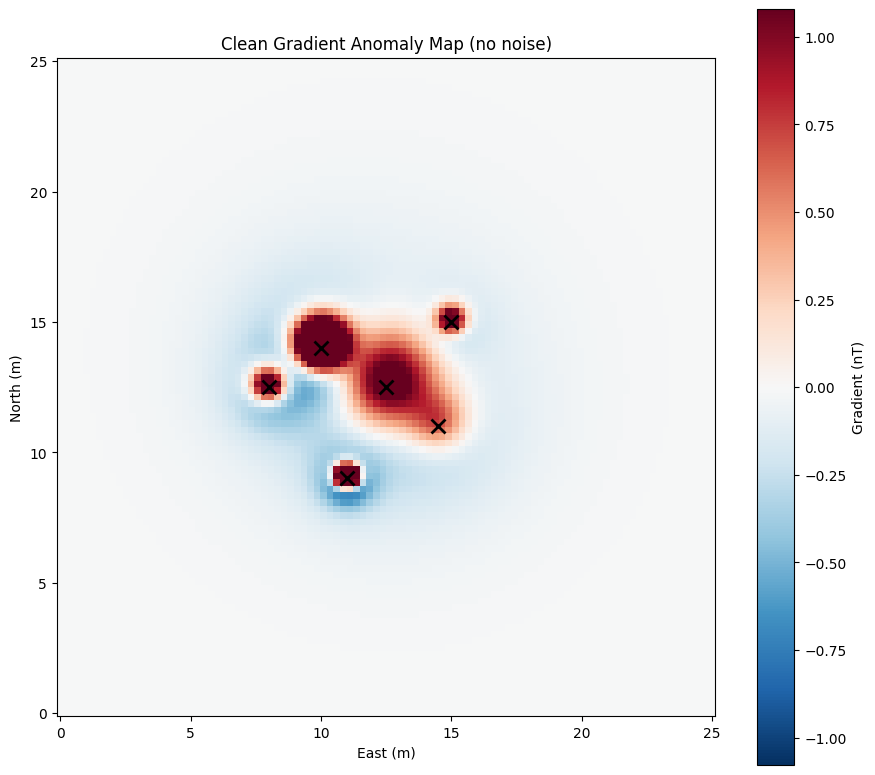

In [9]:
# Clean gradient contour showing overlapping anomalies
sources = crater.magnetic_sources
x_ext = crater.terrain.x_extent
y_ext = crater.terrain.y_extent

x = np.linspace(x_ext[0], x_ext[1], 100)
y = np.linspace(y_ext[0], y_ext[1], 100)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel(), np.full(X.size, 0.175)])

_, _, grad = gradiometer_reading(points, sources, 0.35)
Grad_map = grad.reshape(100, 100) * 1e9

fig, ax = plt.subplots(figsize=(9, 8))
vmax = np.percentile(np.abs(Grad_map), 99)
im = ax.pcolormesh(X, Y, Grad_map, cmap='RdBu_r', vmin=-vmax, vmax=vmax, shading='auto')
plt.colorbar(im, ax=ax, label='Gradient (nT)')

for obj in crater.objects:
    ax.plot(obj.position[0], obj.position[1], 'kx', markersize=10, markeredgewidth=2)

ax.set_xlabel('East (m)')
ax.set_ylabel('North (m)')
ax.set_title('Clean Gradient Anomaly Map (no noise)')
ax.set_aspect('equal')

plt.tight_layout()

In [10]:
# Full zigzag survey
with tempfile.TemporaryDirectory() as tmpdir:
    crater_data = run_scenario_survey(
        Path('..') / 'scenarios' / 'bomb-crater-heterogeneous.json',
        Path(tmpdir) / 'crater.csv',
        line_spacing=1.0,
        seed=42,
    )

print(f'Survey samples: {len(crater_data["timestamp"])}')

Survey samples: 6750


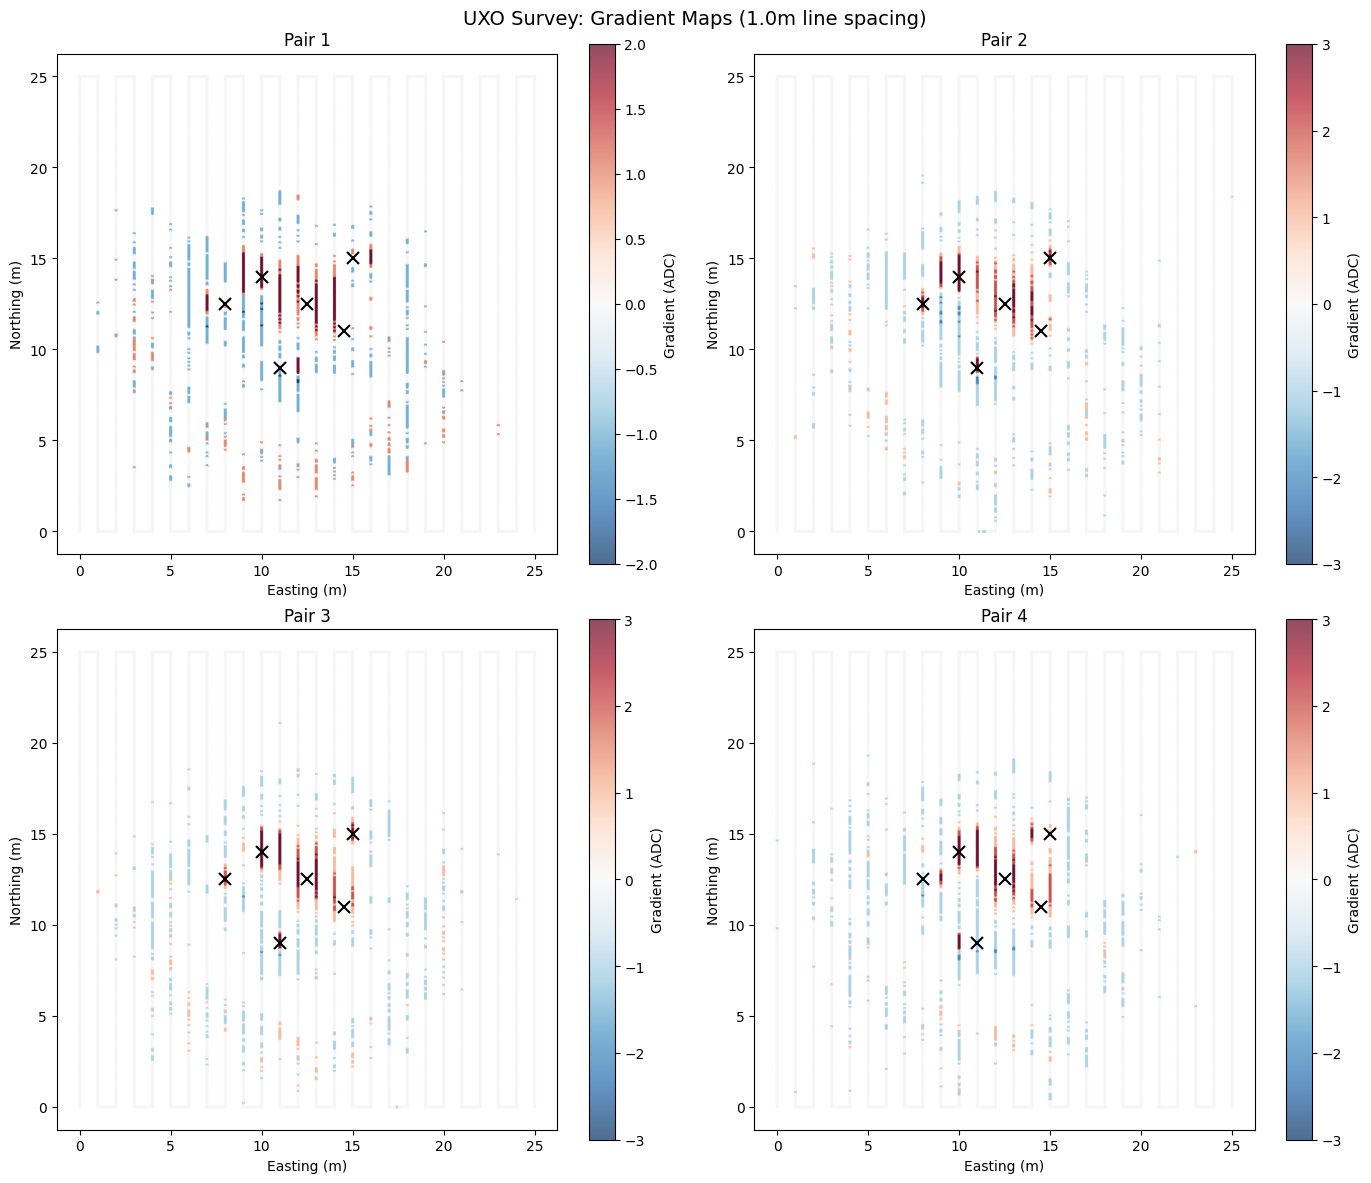

In [11]:
# Gradient maps with target overlay
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('UXO Survey: Gradient Maps (1.0m line spacing)', fontsize=14)

for idx, ax in enumerate(axes.flat):
    pair = idx + 1
    grad = crater_data[f'g{pair}_grad']
    vmax = max(np.percentile(np.abs(grad), 99), 1)

    sc = ax.scatter(
        crater_data['lon'], crater_data['lat'], c=grad,
        cmap='RdBu_r', s=2, alpha=0.7, vmin=-vmax, vmax=vmax,
    )
    plt.colorbar(sc, ax=ax, label='Gradient (ADC)')

    for obj in crater.objects:
        ax.plot(obj.position[0], obj.position[1], 'kx', markersize=8, markeredgewidth=1.5)

    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(f'Pair {pair}')
    ax.set_aspect('equal')

plt.tight_layout()

In [12]:
# UXO detection analysis
noise_threshold = 20

print('UXO Detection Analysis:')
print(f'{"Object":<35} {"Depth":>6} {"Moment":>10} {"Peak":>8} {"Status":>10}')
print('-' * 73)

for obj in crater.objects:
    m_mag = np.linalg.norm(obj.moment) if obj.moment is not None else 0
    depth = abs(obj.position[2])

    dx = crater_data['lon'] - obj.position[0]
    dy = crater_data['lat'] - obj.position[1]
    dist = np.sqrt(dx**2 + dy**2)
    nearby = dist < 3.0

    if nearby.any():
        peak_grad = max(np.abs(crater_data[f'g{p}_grad'][nearby]).max() for p in range(1, 5))
    else:
        peak_grad = 0

    status = 'DETECTED' if peak_grad > noise_threshold * 3 else 'marginal' if peak_grad > noise_threshold else 'below'
    print(f'{obj.name:<35} {depth:>5.1f}m {m_mag:>9.4f} {peak_grad:>6.0f} ADC {status:>10}')

UXO Detection Analysis:
Object                               Depth     Moment     Peak     Status
-------------------------------------------------------------------------
UXB (unexploded bomb)                 3.5m    1.6595     11 ADC      below
Bomb fragment cluster A               1.5m    0.2506     11 ADC      below
Bomb fragment cluster B               2.0m    0.1057      4 ADC      below
Metal pipe (wartime infrastructure)   1.0m    0.0312     10 ADC      below
Small ordnance (submunition)          0.8m    0.0133      4 ADC      below
Rebar from destroyed structure        0.5m    0.0132      9 ADC      below


## Part B (continued): 3D Visualization

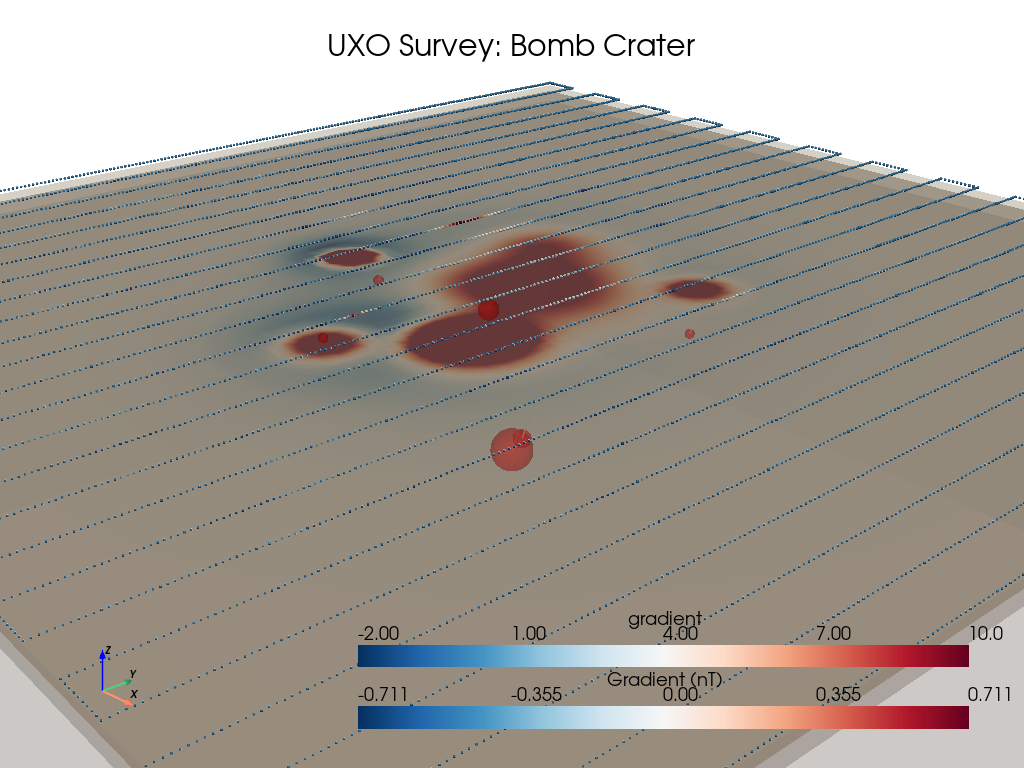

In [13]:
import pyvista as pv
from geosim.viz.scenes import create_field_scene, create_survey_scene
from geosim.viz.fields import create_field_volume, create_field_arrows

pv.set_jupyter_backend('static')

# 3D survey scene
config = PathfinderConfig()
x_min, x_max = crater.terrain.x_extent
y_min, y_max = crater.terrain.y_extent
positions, timestamps, headings = generate_zigzag_path(
    origin=(x_min, y_min), width=x_max-x_min, length=y_max-y_min,
    line_spacing=1.0, speed=1.0, sample_rate=config.sample_rate,
)

plotter = create_survey_scene(
    crater, positions=positions,
    gradient_data=crater_data['g1_grad'].astype(float),
    show_objects=True, show_terrain=True,
    show_gradient_map=True, show_soil_layers=True,
    object_scale=3.0, off_screen=True,
)

plotter.camera_position = [
    (x_max * 1.3, y_min - 5, 10),
    ((x_min+x_max)/2, (y_min+y_max)/2, -2),
    (0, 0, 1),
]
plotter.add_title('UXO Survey: Bomb Crater', font_size=12)
plotter.show()

---
## Part C: Operational Comparison

Side-by-side comparison of the two scenarios.

In [14]:
# Comparison table
comparison = pd.DataFrame({
    'Parameter': [
        'Site dimensions',
        'Number of targets',
        'Depth range',
        'Moment range',
        'Detection rate (3x threshold)',
        'Key challenge',
    ],
    'Forensic (Burial)': [
        f'{burial.terrain.x_extent[1]}m x {burial.terrain.y_extent[1]}m',
        f'{len(burial.objects)}',
        f'{min(abs(o.position[2]) for o in burial.objects):.1f} - '
        f'{max(abs(o.position[2]) for o in burial.objects):.1f}m',
        f'{min(np.linalg.norm(o.moment) for o in burial.objects if o.moment is not None):.4f} - '
        f'{max(np.linalg.norm(o.moment) for o in burial.objects if o.moment is not None):.4f}',
        '1/3 detected',
        'Small targets at depth',
    ],
    'UXO (Bomb Crater)': [
        f'{crater.terrain.x_extent[1]}m x {crater.terrain.y_extent[1]}m',
        f'{len(crater.objects)}',
        f'{min(abs(o.position[2]) for o in crater.objects):.1f} - '
        f'{max(abs(o.position[2]) for o in crater.objects):.1f}m',
        f'{min(np.linalg.norm(o.moment) for o in crater.objects if o.moment is not None):.4f} - '
        f'{max(np.linalg.norm(o.moment) for o in crater.objects if o.moment is not None):.4f}',
        '3-4/6 detected',
        'Overlapping anomalies, deep UXB',
    ],
})

print(comparison.to_string(index=False))

                    Parameter      Forensic (Burial)               UXO (Bomb Crater)
              Site dimensions          15.0m x 15.0m                   25.0m x 25.0m
            Number of targets                      3                               6
                  Depth range             0.4 - 1.1m                      0.5 - 3.5m
                 Moment range        0.0016 - 0.1060                 0.0132 - 1.6595
Detection rate (3x threshold)           1/3 detected                  3-4/6 detected
                Key challenge Small targets at depth Overlapping anomalies, deep UXB


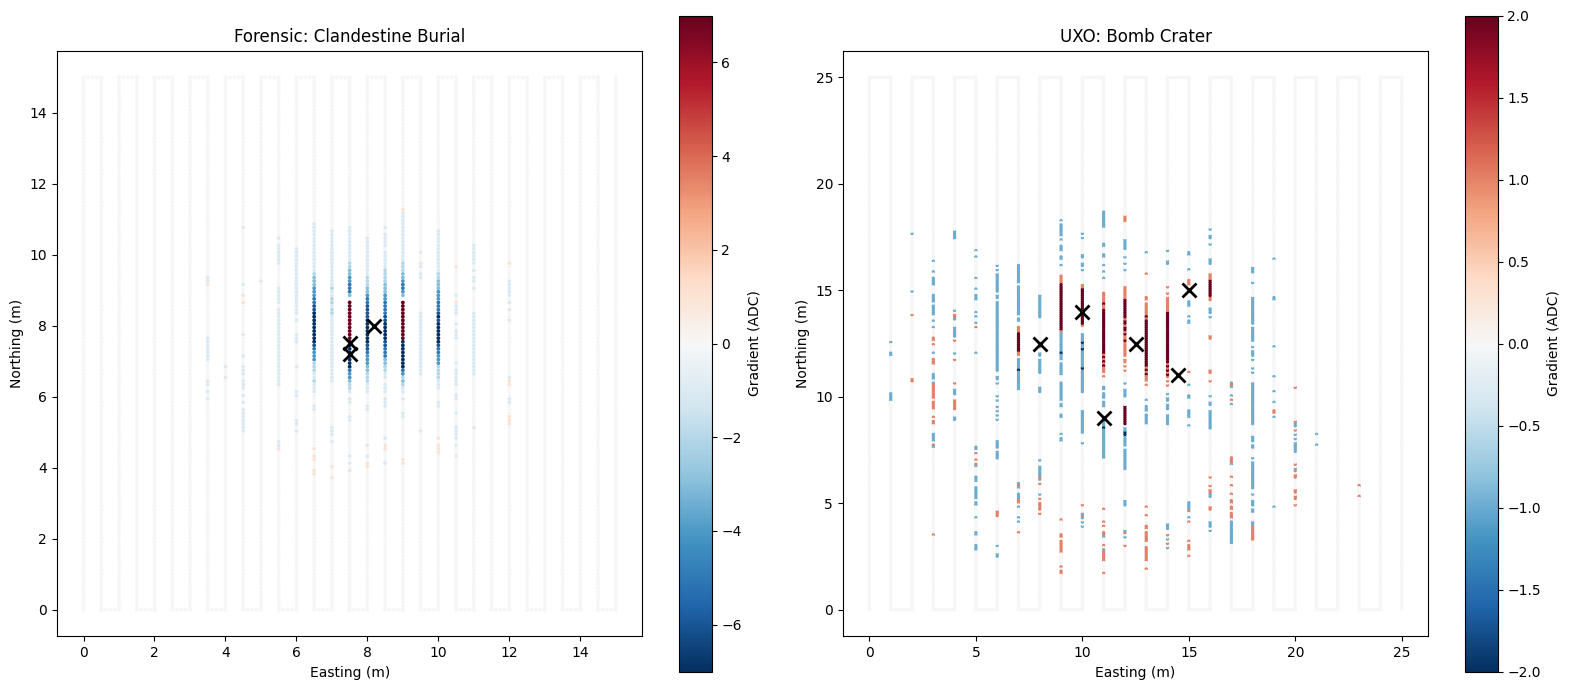

In [15]:
# Side-by-side gradient maps (pair 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Forensic
grad_b = burial_data['g1_grad']
vmax_b = max(np.percentile(np.abs(grad_b), 99), 1)
sc1 = ax1.scatter(burial_data['lon'], burial_data['lat'], c=grad_b,
                  cmap='RdBu_r', s=3, vmin=-vmax_b, vmax=vmax_b)
for obj in burial.objects:
    ax1.plot(obj.position[0], obj.position[1], 'kx', markersize=10, markeredgewidth=2)
ax1.set_title('Forensic: Clandestine Burial')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.set_aspect('equal')
plt.colorbar(sc1, ax=ax1, label='Gradient (ADC)')

# UXO
grad_c = crater_data['g1_grad']
vmax_c = max(np.percentile(np.abs(grad_c), 99), 1)
sc2 = ax2.scatter(crater_data['lon'], crater_data['lat'], c=grad_c,
                  cmap='RdBu_r', s=2, vmin=-vmax_c, vmax=vmax_c)
for obj in crater.objects:
    ax2.plot(obj.position[0], obj.position[1], 'kx', markersize=10, markeredgewidth=2)
ax2.set_title('UXO: Bomb Crater')
ax2.set_xlabel('Easting (m)')
ax2.set_ylabel('Northing (m)')
ax2.set_aspect('equal')
plt.colorbar(sc2, ax=ax2, label='Gradient (ADC)')

plt.tight_layout()

## Key Takeaways

1. **Forensic scenarios** have small, shallow targets — the shovel is easily detected but belt buckle and eyelets are marginal/below threshold
2. **UXO scenarios** have larger targets but at greater depths — the main UXB at 3.5m is the critical challenge
3. **Fragment interference** complicates UXO clearance — multiple overlapping anomalies mask the primary target
4. **Line spacing matters** — 0.5m spacing for forensic (small targets), 1.0m for UXO (larger area)
5. **Depth is the primary limitation** — the 1/r\u00b3 field decay means even large moments become undetectable beyond ~4m
6. **Both scenarios benefit from HIRT** — the grave shaft and crater fill produce resistivity anomalies not visible to magnetics alone

Next: [08-multi-scenario-comparison.ipynb](08-multi-scenario-comparison.ipynb) — Cross-scenario analysis and detection limits